Based on https://github.com/siyi-wind/TIP/tree/main/data/create_dvm_dataset.ipynb

In [59]:
import os
import torch
import operator
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np

from scipy.special import kl_div
from typing import Union, Tuple, Dict, Any
from scipy.spatial.distance import jensenshannon
from sklearn.model_selection import train_test_split

In [60]:
BASE = "/mnt/data/kgutjahr/datasets/DVM"
TABLES= os.path.join(BASE, "tables")
FEATURES = os.path.join(BASE, "images")
SHIFTED_DIR = os.path.join(BASE, "shifted_dists")

In [61]:
color_coding = {0: 'Beige',
                1: 'Black',
                2: 'Blue', 
                3: 'Bronze', 
                4: 'Brown', 
                5: 'Burgundy', 
                6: 'Gold', 
                7: 'Green', 
                8: 'Grey', 
                9: 'Indigo', 
                10: 'Magenta', 
                11: 'Maroon', 
                12: 'Multicolour', 
                13: 'Navy', 
                14: 'Orange', 
                15: 'Pink', 
                16: 'Purple', 
                17: 'Red', 
                18: 'Silver', 
                19: 'Turquoise', 
                20: 'White', 
                21: 'Yellow'}

In [62]:
def get_color_counts(df: pd.DataFrame) -> pd.DataFrame:
    color_counts = df["Color"].value_counts()
    color_percentages = df["Color"].value_counts(normalize=True) * 100

    # Optional: Combine into one DataFrame for clarity
    color_summary = pd.DataFrame({
        'Count': color_counts,
        'Percentage': color_percentages.round(3)
    })
    return color_summary

In [63]:
def plot_color_distributions(df: pd.DataFrame) -> None:
    plt.figure(figsize=(10, 6))
    ax = df["Count"].plot(kind='bar', color='skyblue', edgecolor='black', width=1)

    # Customize the plot
    plt.title('Color distribution')
    plt.xlabel('Colors')
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, fontsize=10)  # Rotate labels for better readability
    plt.tight_layout()

    # Show the plot
    plt.show()

# Get color distribution of entire Dataset

In [64]:
physical_df = pd.read_csv(os.path.join(TABLES,'Ad_table_physical_filled_jittered_50.csv'))[['Adv_ID', 'Wheelbase','Height','Width','Length']]
physical_df

,Adv_ID,Wheelbase,Height,Width,Length
0,10_1$$1,3134.0,1534.0,2118.0,5387.0
1,10_1$$2,3102.0,1551.0,2075.0,5433.0
2,10_1$$3,3122.0,1490.0,2122.0,5369.0
3,10_1$$4,3135.0,1513.0,2094.0,5353.0
4,10_1$$5,3105.0,1514.0,2077.0,5376.0
...,...,...,...,...,...
268250,97_1$$1,NaN,NaN,NaN,NaN
268251,97_1$$2,NaN,NaN,NaN,NaN
268252,99_1$$1,NaN,NaN,NaN,NaN
268253,99_1$$2,NaN,NaN,NaN,NaN


In [65]:
ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]
ad_data

/tmp/ipykernel_944075/3060315506.py:1: DtypeWarning: Columns (13) have mixed types. Specify dtype option on import or set low_memory=False.
  ad_data = pd.read_csv(os.path.join(TABLES, 'Ad_table.csv'))[['Adv_ID', 'Genmodel', "Maker"]]


,Adv_ID,Genmodel,Maker
0,10_1$$1,Arnage,Bentley
1,10_1$$2,Arnage,Bentley
2,10_1$$3,Arnage,Bentley
3,10_1$$4,Arnage,Bentley
4,10_1$$5,Arnage,Bentley
...,...,...,...
268250,97_1$$1,Sport,Westfield
268251,97_1$$2,Sport,Westfield
268252,99_1$$1,E10,Zenos
268253,99_1$$2,E10,Zenos


In [66]:
unique_cars = ad_data.drop_duplicates(subset=["Maker", "Genmodel"]).reset_index(drop=True)
unique_cars['Genmodel_ID'] = unique_cars['Adv_ID'].str.partition('$$')[0]
unique_cars['Car Name'] = unique_cars['Maker'].str.cat(unique_cars['Genmodel'], sep=' ')
unique_cars.drop(["Maker", "Genmodel", "Adv_ID"], axis=1, inplace=True)

unique_cars

,Genmodel_ID,Car Name
0,10_1,Bentley Arnage
1,10_2,Bentley Azure
2,10_3,Bentley Bentayga
3,10_4,Bentley Brooklands
4,10_5,Bentley Continental
...,...,...
911,96_7,Volvo V40
912,96_8,Volvo V40 Cross Country
913,96_9,Volvo V50
914,97_1,Westfield Sport


In [67]:
data_path = os.path.join(FEATURES, "data_df_unnorm.csv")
full_data_df = pd.read_csv(data_path)
full_data_df = full_data_df.loc[:, ~full_data_df.columns.str.contains('^Unnamed')]
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
0,10_1$$1,2018,4,2000.0,60000,21500,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$1$$image_...,45
1,10_1$$13,2018,4,2000.0,53444,21995,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$13$$image...,0
2,10_1$$16,2017,12,2000.0,49700,29500,5.0,4.0,145000,4.4,Blue,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Blue$$10_1$$16$$image_1...,0
3,10_1$$18,2018,4,2000.0,75000,17995,5.0,4.0,145000,6.8,White,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$White$$10_1$$18$$image_...,90
4,10_1$$26,2017,5,2000.0,98000,17945,5.0,4.0,145000,6.8,Silver,Saloon,Automatic,Petrol,10_1,Bentley$$Arnage$$2000$$Silver$$10_1$$26$$image...,225
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183820,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,Silver,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
183821,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,Silver,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
183822,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,Grey,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
183823,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,Grey,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [68]:
minimum_population = 100
values = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).values
codes = (full_data_df.value_counts(subset=['Genmodel_ID'])>=minimum_population).index
populated_codes = []
for i, v in enumerate(values):
  if v:
    populated_codes.append(codes[i][0])
    
full_data_df = full_data_df[full_data_df['Genmodel_ID'].isin(populated_codes)]

full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,Color,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint
25,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,Grey,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225
26,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,Silver,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225
27,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,Blue,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225
28,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,White,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0
29,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,Grey,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
183820,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,Silver,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45
183821,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,Silver,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0
183822,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,Grey,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45
183823,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,Grey,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315


In [69]:
full_data_df = full_data_df.merge(physical_df, on='Adv_ID')
full_data_df.dropna(inplace=True)
full_data_df

,Adv_ID,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,Door_num,Entry_price,Engine_size,...,Bodytype,Gearbox,Fuel_type,Genmodel_ID,Image_name,Predicted_viewpoint,Wheelbase,Height,Width,Length
0,10_3$$1,2018,3,2016.0,12661,129990,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,225,2981.0,1746.0,2185.0,5123.0
1,10_3$$3,2018,4,2016.0,15141,135000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,225,2953.0,1699.0,2268.0,5184.0
2,10_3$$10,2018,6,2016.0,16526,127895,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,225,2974.0,1715.0,2257.0,5130.0
3,10_3$$11,2018,7,2016.0,16200,125995,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,0,3031.0,1788.0,2184.0,5130.0
4,10_3$$12,2018,6,2016.0,6000,145000,5.0,5.0,135800,6.0,...,SUV,Automatic,Petrol,10_3,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,0,3006.0,1727.0,2237.0,5154.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176409,96_9$$353,2018,5,2004.0,100390,1999,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,45,2591.0,1496.0,1762.0,4471.0
176410,96_9$$374,2018,5,2004.0,149000,1450,5.0,5.0,17165,2.0,...,Estate,Manual,Diesel,96_9,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,0,2618.0,1449.0,1753.0,4536.0
176411,96_9$$457,2018,5,2004.0,98167,3995,5.0,5.0,17165,2.4,...,Estate,Automatic,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,45,2627.0,1467.0,1722.0,4509.0
176412,96_9$$477,2018,2,2004.0,152230,1495,5.0,5.0,17165,1.8,...,Estate,Manual,Petrol,96_9,Volvo$$V50$$2004$$Grey$$96_9$$477$$image_0.jpg,315,2673.0,1457.0,1767.0,4512.0


In [70]:
color_counts = get_color_counts(df=full_data_df)
color_counts

,Count,Percentage
Black,34005,19.276
Silver,29902,16.950
Blue,27793,15.754
Grey,26150,14.823
White,23369,13.247
Red,19514,11.061
Green,3500,1.984
Brown,2300,1.304
Yellow,2233,1.266
Orange,1966,1.114


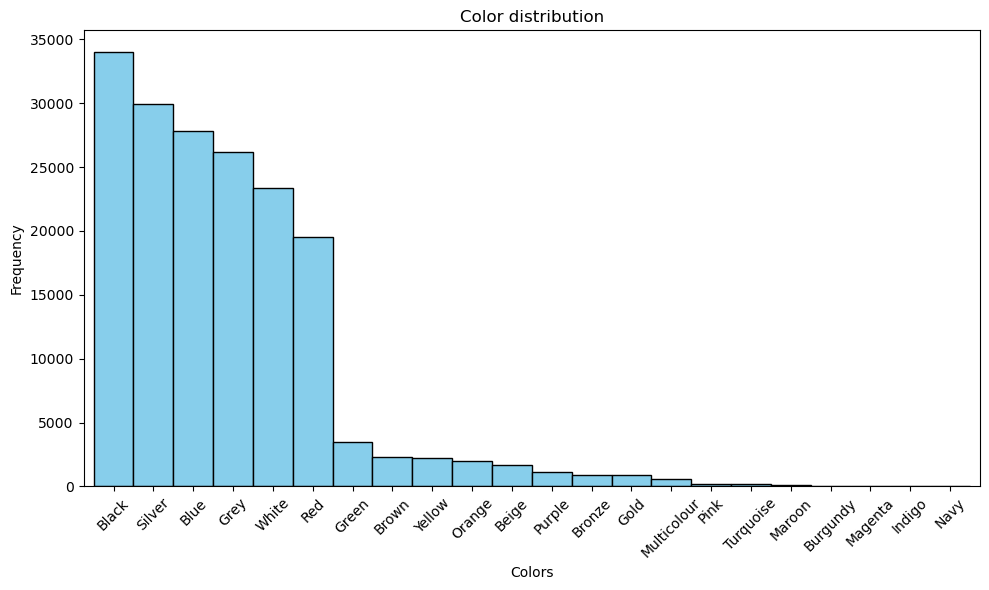

In [71]:
plot_color_distributions(df=color_counts)

## Plot Color Distribution of splits

In [72]:
train_df = pd.read_csv(os.path.join(FEATURES,f'dvm_full_features_train_noOH_all_views.csv'))
train_df['Color'] = train_df['Color'].map(color_coding)
val_df = pd.read_csv(os.path.join(FEATURES,f'dvm_full_features_val_noOH_all_views.csv'))
val_df['Color'] = val_df['Color'].map(color_coding)
test_df = pd.read_csv(os.path.join(FEATURES,f'dvm_full_features_test_noOH_all_views.csv'))
test_df['Color'] = test_df['Color'].map(color_coding)

In [73]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

print(f"Total Size: {train_df.shape[0] + val_df.shape[0] + test_df.shape[0]}")

(70565, 17)
(17642, 17)
(88207, 17)
Total Size: 176414


Relative Size between splits

### Training Split

In [74]:
train_color_counts = get_color_counts(df=train_df)
train_color_counts

,Count,Percentage
Black,13519,19.158
Silver,11977,16.973
Blue,11055,15.666
Grey,10509,14.893
White,9375,13.286
Red,7895,11.188
Green,1381,1.957
Brown,918,1.301
Yellow,895,1.268
Orange,786,1.114


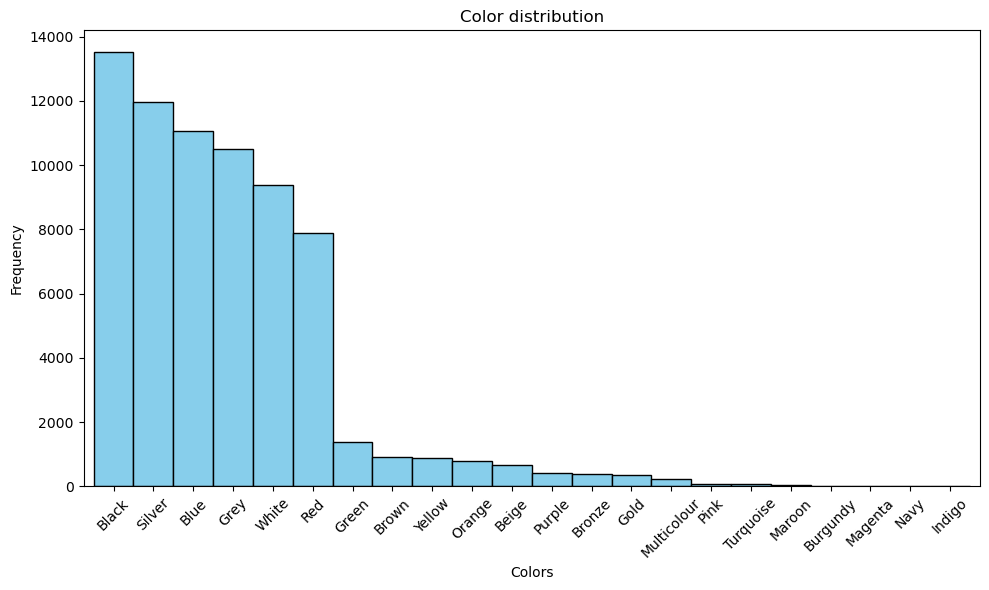

In [75]:
plot_color_distributions(df=train_color_counts)

### Validation Split

In [76]:
val_color_counts = get_color_counts(df=val_df)
val_color_counts

,Count,Percentage
Black,3469,19.663
Silver,3022,17.130
Blue,2823,16.002
Grey,2559,14.505
White,2318,13.139
Red,1843,10.447
Green,344,1.950
Yellow,235,1.332
Brown,233,1.321
Orange,202,1.145


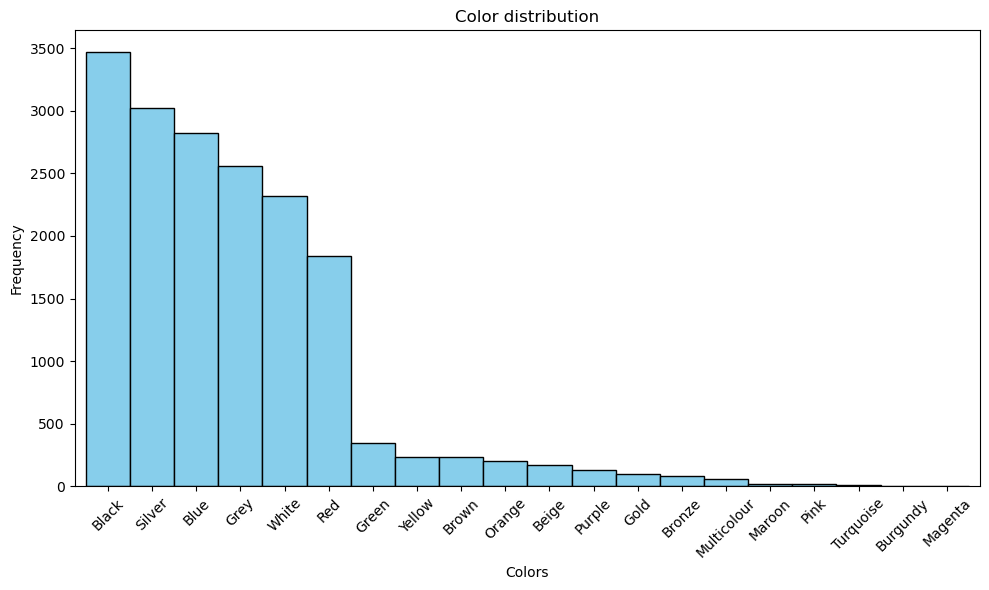

In [77]:
plot_color_distributions(df=val_color_counts)

### Test Split

In [78]:
test_color_counts = get_color_counts(df=test_df)
test_color_counts

,Count,Percentage
Black,17017,19.292
Silver,14903,16.895
Blue,13915,15.775
Grey,13082,14.831
White,11676,13.237
Red,9776,11.083
Green,1775,2.012
Brown,1149,1.303
Yellow,1103,1.250
Orange,978,1.109


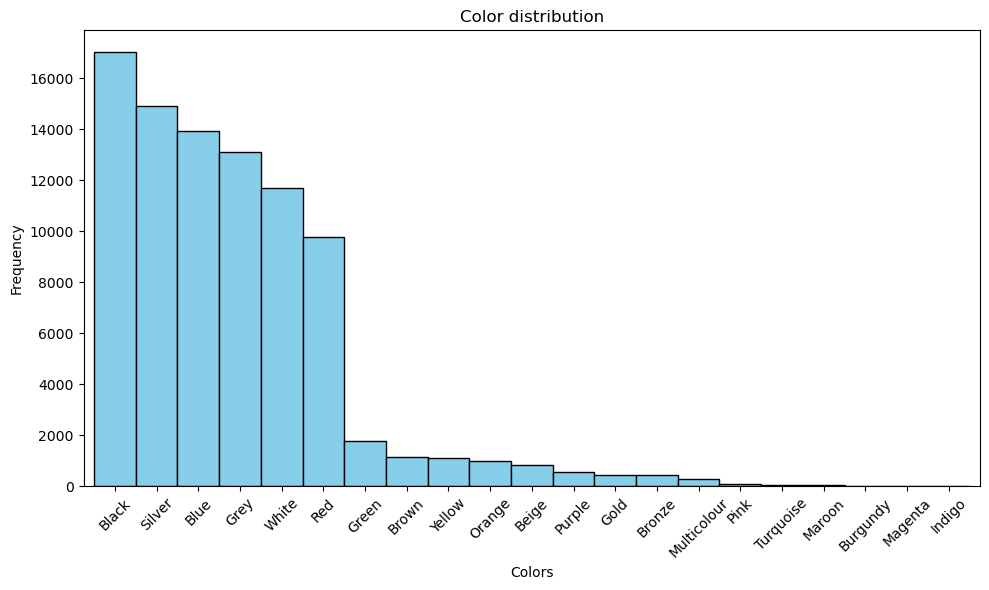

In [79]:
plot_color_distributions(df=test_color_counts)

## See if distributions are the same

In [80]:
def plot_compare_distribution(train_dist: Union[pd.Series, pd.DataFrame], val_dist: Union[pd.Series, pd.DataFrame], test_dist: Union[pd.Series, pd.DataFrame], feature: list[Any]) -> None:
    plt.figure(figsize=(12, 6))
    plt.plot(feature, train_dist.reindex(feature), label='Train', marker='o')
    plt.plot(feature, val_dist.reindex(feature), label='Validation', marker='s')
    plt.plot(feature, test_dist.reindex(feature), label='Test', marker='^')
    plt.xticks(rotation=45)
    plt.ylabel('Relative Frequency')
    plt.title('Color Distribution Comparison')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [81]:
def calc_KL(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> np.ndarray:
    kl = np.sum(kl_div(first_dist, second_dist))
    return kl

In [82]:
def calc_JS(first_dist: pd.DataFrame, second_dist: pd.DataFrame) -> float:
    js = jensenshannon(first_dist, second_dist)
    return float(js)

In [83]:
colors = list(color_coding.values())

In [84]:
def fill_missing_vals(df: pd.DataFrame, fill_values: list[str]) -> pd.DataFrame:
    # fill missing color with 0 if it isn't present in distribution
    for fill in fill_values:
        if fill not in df:
            df[fill] = 0
    return df

In [85]:
train_dist = train_color_counts['Count'] / train_color_counts['Count'].sum()
val_dist = val_color_counts['Count'] / val_color_counts['Count'].sum()
test_dist = test_color_counts['Count'] / test_color_counts['Count'].sum()

#### Calculate Kullback-Leibler divergence

In [86]:
train_val_kl = calc_KL(first_dist=train_dist, second_dist=val_dist)
train_val_kl

0.0009321821806920966

In [87]:
train_test_kl = calc_KL(first_dist=train_dist, second_dist=test_dist)
train_test_kl

0.00016459560488363636

#### Calculate Jensen Shannonen divergence

In [88]:
train_df_filled = fill_missing_vals(df=train_dist, fill_values=colors)
val_df_filled = fill_missing_vals(df=val_dist, fill_values=colors)
train_val_js = calc_JS(first_dist=train_df_filled, second_dist=val_df_filled)
train_val_js

0.013530758435503982

In [89]:
test_df_filled = fill_missing_vals(df=test_dist, fill_values=colors)
train_test_js = calc_JS(first_dist=train_df_filled, second_dist=test_df_filled)
train_test_js

0.006184439960490339

#### Plot the distributions 

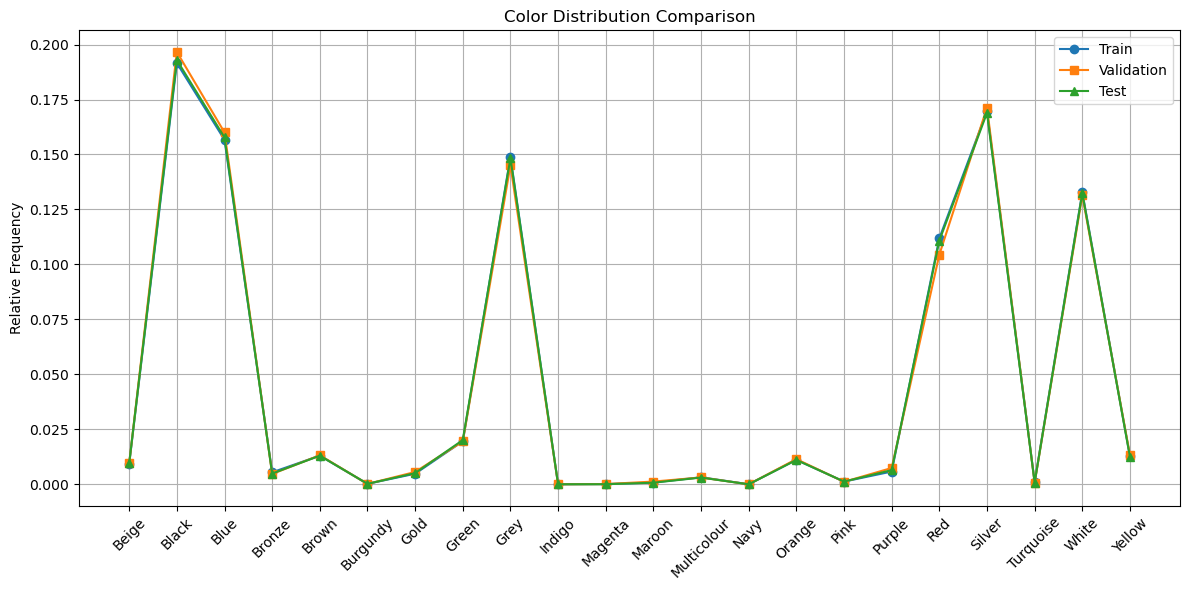

In [90]:
plot_compare_distribution(train_dist=train_dist, val_dist=val_dist, test_dist=test_dist, feature=colors)

# Create datasets that contain distribution shifts

In [120]:
def data_split(df: pd.DataFrame, nclasses: int, split: float) -> np.ndarray:
  critical_ids = df.groupby('Genmodel_ID', as_index=False).head(n=1)['Adv_ID']
  other_ids = df.loc[~df['Adv_ID'].isin(critical_ids)]['Adv_ID'].values
  to_fill_size = (int(len(df)*split)-len(critical_ids))
  stratify = None
  if to_fill_size >= nclasses:
    stratify = df.set_index('Adv_ID').loc[other_ids]['Genmodel_ID']
  if to_fill_size > 0:
    # make sure that at least two instances of each class is available. If not, remove the singular classes
    if stratify is not None:
      valid_stratify_labels = stratify.value_counts()[stratify.value_counts() >= 2].index
      valid_stratify = stratify[stratify.isin(valid_stratify_labels)]
      invalid_part = stratify[~stratify.isin(valid_stratify_labels)]
    else:
      valid_stratify = stratify
      invalid_part = None

    if invalid_part is not None:
        valid_other_ids = other_ids[~np.isin(other_ids, invalid_part.index)]
    else:
        valid_other_ids = other_ids

    _, low_data_ids = train_test_split(valid_other_ids, test_size=to_fill_size, random_state=2023, stratify=valid_stratify)
  else:
    low_data_ids = []
  new_ids = np.concatenate([critical_ids,low_data_ids])
  return new_ids

In [ ]:

def create_shift_mask(df: pd.DataFrame, filters: list[Dict[str, str]], filter_cond: str) -> pd.Series:
    first_bool = True if filter_cond == "and" else False
    
    ops = {
        "==": operator.eq,
        "!=": operator.ne,
        ">": operator.gt,
        ">=": operator.ge,
        "<": operator.lt,
        "<=": operator.le,
    }

    mask = pd.Series(first_bool, index=df.index)
    for f in filters:
        for col, val in f.items():
            if filter_cond == "and":
                if isinstance(val, tuple):
                    op_str, threshold = val
                    mask &= ops[op_str](df[col], threshold)
                else:
                    mask &= df[col] == val
            else:
                if isinstance(val, tuple):
                    op_str, threshold = val
                    mask |= ops[op_str](df[col], threshold)
                else:
                    mask |= df[col] == val
                    
    return mask

In [170]:
def create_cutted_split(df: pd.DataFrame, desired_size: int) -> pd.DataFrame:
    if desired_size >= len(df):
        print("Too little data. Returning full DataFrame.")
        return df.copy()
         
    desired_size = min(desired_size, len(df)-1)
    x = desired_size / len(df)
    df_ids = data_split(df=df, nclasses=df["Genmodel_ID"].nunique(), split=x)
    cutted_df = df.loc[df['Adv_ID'].isin(df_ids)]
    return cutted_df

In [178]:

def create_shifted_splits(df: pd.DataFrame, split: list[Dict[str, Any]], split_cond: str, ratio: list[float], mode: int = 0) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    '''
    Creates shifted versions of the given DataFrames. Also normalizes/categorizes the data
    
    Args:
    -----
        df (pd.DataFrame): the original df
        split (list[Dict[str, str]]): The elements that needs to be filtered
        ratio (list[float]): Expects a list containing two float numbers:
                                first: validation size
                                scond: test size
        mode (int): The mode, i.e. if the newly generated test df should contain all split elements and train/val contain everything else (mode==0) or vice versa (mode==1) 
    '''
    mask = create_shift_mask(df=df, filters=split, filter_cond=split_cond)
    
    no_df = df[~mask]
    only_df = df[mask]
    
    test_df = pd.DataFrame()
    train_val_df = pd.DataFrame()
    if mode == 0:
        test_df = only_df
        train_val_df = no_df
    elif mode == 1:
        test_df = no_df
        train_val_df = only_df
    else:
        raise ValueError("mode can only be 0 or 1.")
        
    if len(test_df) > len(train_val_df):
        # cut test to correct size
        desired_test_size = int((ratio[1] / (1 - ratio[1])) * len(train_val_df))
        test_df = create_cutted_split(df=test_df, desired_size=desired_test_size)
    elif len(test_df) < len(train_val_df):
        # cut train_val to correct size
        desired_train_val_size = int(len(test_df) * (1 / ratio[1] - 1))
        train_val_df = create_cutted_split(df=train_val_df, desired_size=desired_train_val_size)

    desired_val_size = int((len(test_df) + len(train_val_df)) * ratio[0])
    desired_val_size = min(desired_val_size, len(train_val_df)-1)
    
    x_val = desired_val_size / len(train_val_df)
    
    val_ids = data_split(df=train_val_df, nclasses=train_val_df["Genmodel_ID"].nunique(), split=x_val)
    val_df = train_val_df.loc[train_val_df['Adv_ID'].isin(val_ids)]
    train_df = train_val_df.loc[~train_val_df['Adv_ID'].isin(val_ids)]
    
    print(f"Shape of train df:\t{train_df.shape}")
    print(f"Shape of val df:\t{val_df.shape}")
    print(f"Shape of test df:\t{test_df.shape}")
    total_size = train_df.shape[0] + val_df.shape[0] + test_df.shape[0]
    print(f"Total Size: {total_size}")
    print(f"Ratio -> Train: {round(train_df.shape[0] / total_size, 2)} | Val: {round(val_df.shape[0] / total_size, 2)} | Test: {round(test_df.shape[0] / total_size, 2)}")
    
    return train_df, val_df, test_df

In [94]:
def categorize(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, categorical_columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame, Dict[str, dict]]:
    # Deep copies to ensure no slice/view issues
    train_df_copy = train_df.copy(deep=True)
    val_df_copy = val_df.copy(deep=True)
    test_df_copy = test_df.copy(deep=True)
    
    category_mappings = {}

    for col in categorical_columns:
        # Combine all categories
        all_categories = pd.Index(
            pd.concat([
                train_df_copy[col],
                val_df_copy[col],
                test_df_copy[col]
            ]).dropna().unique()
        )
        
        # Store the mapping
        mapping = {category: code for code, category in enumerate(all_categories)}
        category_mappings[col] = mapping

        # Assign categories
        for df in (train_df_copy, val_df_copy, test_df_copy):
            df[col] = pd.Categorical(df[col], categories=all_categories)
            df[col] = df[col].cat.codes

    return train_df_copy, val_df_copy, test_df_copy, category_mappings

In [95]:
def normalize(train_df: pd.DataFrame, val_df: pd.DataFrame, test_df: pd.DataFrame, continuous_columns: list[str]) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    # Compute mean and std from training set only
    mean = train_df[continuous_columns].mean()
    std = train_df[continuous_columns].std()

    # use copies for more sanitary workflow
    train_df_copy = train_df.copy()
    val_df_copy = val_df.copy()
    test_df_copy = test_df.copy()

    # Apply normalization using training stats
    train_df_copy[continuous_columns] = (train_df_copy[continuous_columns] - mean) / std
    val_df_copy[continuous_columns] = (val_df_copy[continuous_columns] - mean) / std
    test_df_copy[continuous_columns] = (test_df_copy[continuous_columns] - mean) / std

    return train_df_copy, val_df_copy, test_df_copy

In [96]:
def reorder_df(df: pd.DataFrame, new_order: list[str]) -> pd.DataFrame:
    other_columns = list(set(list(df.columns)) - set(new_order))
    
    new_order = new_order + other_columns
    return df[new_order]

In [97]:
def get_lengths(df_list: list[pd.DataFrame], continuous_columns: list[str], categorical_columns: list[str]) -> Dict[str, int]:
    continuous_length = {i: 1 for i in continuous_columns}
    
    max_list = {i: 0 for i in categorical_columns}
    for df in df_list:
        for col in categorical_columns:
            df_col_max = df[col].max()
            max_list[col] = df_col_max if df_col_max > max_list[col] else max_list[col]
            
    max_list = {k: v+1 for k, v in max_list.items()}
    
    return max_list | continuous_length 

In [98]:
def create_dist_dfs(df: pd.DataFrame, cols: list[str], fill_values: list[Any] = [], fill: bool = True) -> pd.DataFrame:
    df_color_counts = get_color_counts(df=df)

    df_dist = pd.DataFrame()
    for col in cols:
        if df_dist.empty:
            df_dist = df_color_counts["Count"] / df_color_counts["Count"].sum()
        else:
            dist = df_color_counts["Count"] / df_color_counts["Count"].sum()
            df_dist = pd.concat([df_dist, dist], axis=1)
    
    if fill and len(colors) > 0:
        df_dist = fill_missing_vals(df=df_dist, fill_values=fill_values)
    
    return df_dist

In [99]:
def create_splitted_train(train_df: pd.DataFrame, low_data_split: float, nclasses: int) -> Tuple[pd.DataFrame, pd.DataFrame]:
    if low_data_split == 1.0:
        return train_df, pd.DataFrame()
    low_train_ids = data_split(df=train_df, nclasses=nclasses, split=low_data_split)
    low_train_df = train_df.loc[train_df['Adv_ID'].isin(low_train_ids)]
    non_low_train_df = train_df.loc[~train_df['Adv_ID'].isin(low_train_ids)]
    return low_train_df, non_low_train_df

In [100]:
def save_lengths(lengths: Dict[str, int], file_name: str, save_directory: str) -> None:
    # save lengths list
    lengths_list = list(lengths.values())
    lengths_path = os.path.join(save_directory, file_name)
    if not os.path.exists(lengths_path):
        torch.save(lengths_list, lengths_path)
        print(f"Saved lengths to {lengths_path}")

In [101]:
def get_paths(series: pd.Series):
  paths = []
  for im_name in series:
      split = im_name.split('$$')
      path = os.path.join(FEATURES, split[0], split[1], split[2], split[3], im_name)
      assert os.path.exists(path)
      paths.append(path)
  return paths

def save_dataset(df: pd.DataFrame, save_directory: str, split: str, k: str, keep_cols: list[str], shift_name: str) -> None:
    labels_path = f"labels_{shift_name}_{split}{k}.pt"
    labels_path = os.path.join(save_directory, labels_path)
    labels = list(df["Genmodel_ID"].reset_index(drop=True))
    if not os.path.exists(labels_path):
        torch.save(labels, labels_path)
        print(f"Saved labels to {labels_path}")
    
    
    img_path = f"image_paths_{shift_name}_{split}{k}.pt"
    img_path = os.path.join(save_directory, img_path)
    imgs = df["Image_name"].reset_index(drop=True)
    image_paths = get_paths(series=imgs)
    if not os.path.exists(img_path):
        torch.save(image_paths, img_path)
        print(f"Saved image paths to {img_path}")
    
    dvm_features_path = f"dvm_features_{shift_name}_{split}{k}.csv"
    dvm_features_path = os.path.join(save_directory, dvm_features_path)
    data_df = df[keep_cols].reset_index(drop=True)
    if not os.path.exists(dvm_features_path):
        data_df.to_csv(path_or_buf=dvm_features_path, index=False, header=False)
        print(f"Saved DVM Features to {dvm_features_path}")

### Train, Val: No Black. Test: Only Black

In [102]:
continuous_columns = ['Adv_year', 'Adv_month', 'Reg_year', 'Runned_Miles', 'Price', 'Seat_num', 'Door_num', 'Entry_price',  'Engine_size', 'Wheelbase','Height','Width','Length']
categorical_columns = ['Color', 'Bodytype', 'Gearbox', 'Fuel_type']

reorder_columns = categorical_columns + continuous_columns

In [179]:
ratio = [0.1, 0.3]
train_no_black_df, val_no_black_df, test_only_black_df = create_shifted_splits(df=full_data_df, 
                                                                               split=[{"Color": "Black"}, {"Color": "Blue"}],
                                                                               split_cond="or",
                                                                               ratio=ratio,
                                                                               mode=0)

cat_plus_gen_cols = categorical_columns + ["Genmodel_ID"]
train_no_black_df, val_no_black_df, test_only_black_df, cat_mapping = categorize(train_df=train_no_black_df,
                                                                    val_df=val_no_black_df,
                                                                    test_df=test_only_black_df,
                                                                    categorical_columns=cat_plus_gen_cols)

train_no_black_df, val_no_black_df, test_only_black_df = normalize(train_df=train_no_black_df,
                                                                    val_df=val_no_black_df,
                                                                    test_df=test_only_black_df,
                                                                    continuous_columns=continuous_columns)

train_no_black_df = reorder_df(df=train_no_black_df, new_order=reorder_columns)
val_no_black_df = reorder_df(df=val_no_black_df, new_order=reorder_columns)
test_only_black_df = reorder_df(df=test_only_black_df, new_order=reorder_columns)

display(train_no_black_df)
display(val_no_black_df)
display(test_only_black_df)

Too little data. Returning full DataFrame.
Shape of train df:	(96975, 21)
Shape of val df:	(17641, 21)
Shape of test df:	(61798, 21)
Total Size: 176414
Ratio -> Train: 0.55 | Val: 0.1 | Test: 0.35


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Genmodel_ID,Image_name,Adv_ID,Predicted_viewpoint
1,0,0,0,0,0.005915,-0.842562,0.843418,-0.871004,7.792239,0.130046,...,7.941912,5.977546,1.820037,1.385340,2.444150,2.077009,0,Bentley$$Bentayga$$2016$$Silver$$10_3$$3$$imag...,10_3$$3,225
3,1,0,0,0,0.005915,0.610747,0.843418,-0.843998,7.220553,0.130046,...,7.941912,5.977546,2.263927,2.128045,1.902933,1.945926,0,Bentley$$Bentayga$$2016$$White$$10_3$$11$$imag...,10_3$$11,0
4,2,0,0,0,0.005915,0.126311,0.843418,-1.104117,8.427094,0.130046,...,7.941912,5.977546,2.121655,1.619000,2.244415,2.004185,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$12$$image...,10_3$$12,0
6,2,0,0,0,-2.394181,1.579620,0.843418,-0.765376,7.157067,0.130046,...,7.941912,5.977546,2.007837,2.052940,1.915819,1.882812,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$41$$image...,10_3$$41,135
7,3,0,0,0,0.005915,1.095184,0.843418,-1.146884,7.154210,0.130046,...,7.941912,5.977546,1.848492,1.919420,2.076896,2.040597,0,Bentley$$Bentayga$$2016$$Green$$10_3$$47$$imag...,10_3$$47,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176407,4,6,0,0,0.005915,-0.358126,-2.020343,1.981610,-0.673545,0.130046,...,-0.171239,0.816538,-0.222996,-0.308697,-0.764496,0.508870,285,Volvo$$V50$$2004$$Red$$96_9$$310$$image_0.jpg,96_9$$310,45
176408,0,6,1,0,-2.394181,3.032930,-2.020343,2.185625,-0.728142,0.130046,...,-0.171239,0.816538,-0.143324,-0.292007,-0.448786,0.348657,285,Volvo$$V50$$2004$$Silver$$96_9$$315$$image_0.jpg,96_9$$315,0
176409,0,6,0,0,0.005915,-0.358126,-2.020343,1.303005,-0.651389,0.130046,...,-0.171239,0.816538,-0.240069,-0.308697,-0.816040,0.346230,285,Volvo$$V50$$2004$$Silver$$96_9$$353$$image_0.jpg,96_9$$353,45
176411,2,6,0,0,0.005915,-0.358126,-2.020343,1.246314,-0.524672,0.130046,...,-0.171239,0.816538,-0.035197,-0.550702,-1.073763,0.438473,285,Volvo$$V50$$2004$$Grey$$96_9$$457$$image_0.jpg,96_9$$457,45


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Genmodel_ID,Image_name,Adv_ID,Predicted_viewpoint
0,2,0,0,0,0.005915,-1.326999,0.843418,-0.934249,7.474177,0.130046,...,7.941912,5.977546,1.979382,1.777555,1.909376,1.928934,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$1$$image_...,10_3$$1,225
17,2,0,0,0,0.005915,1.095184,0.843418,-0.748111,7.601148,0.130046,...,7.941912,5.977546,1.848492,1.977835,2.450593,2.064872,0,Bentley$$Bentayga$$2016$$Grey$$10_3$$93$$image...,10_3$$93,225
58,2,0,0,0,0.005915,-0.842562,1.320711,-1.243102,9.696803,0.130046,...,7.941912,3.110319,2.246855,1.752520,2.424821,1.851255,0,Bentley$$Bentayga$$2018$$Grey$$10_3$$82$$image...,10_3$$82,225
62,2,0,0,0,0.005915,1.095184,1.320711,-1.035517,8.362338,0.130046,...,7.941912,5.977546,2.138728,1.861005,2.147769,1.858538,0,Bentley$$Bentayga$$2018$$Grey$$10_3$$92$$image...,10_3$$92,0
77,2,0,0,0,0.005915,0.126311,1.320711,-1.255598,13.502755,0.130046,...,7.941912,3.110319,1.871255,1.635690,2.289517,1.953208,0,Bentley$$Bentayga$$2018$$Grey$$10_3$$129$$imag...,10_3$$129,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176391,2,6,1,1,0.005915,-0.358126,-1.543049,1.905104,-0.635454,0.130046,...,-0.265955,0.243092,0.260730,-1.034713,-0.764496,0.334092,285,Volvo$$V50$$2006$$Grey$$96_9$$360$$image_0.jpg,96_9$$360,90
176398,0,6,1,0,0.005915,-1.811435,-1.543049,0.896505,-0.524989,0.130046,...,-0.265955,-0.043630,0.158294,-0.350422,-0.654964,0.533144,285,Volvo$$V50$$2006$$Silver$$96_9$$450$$image_1.jpg,96_9$$450,315
176405,2,6,1,1,0.005915,0.126311,-2.020343,0.698457,-0.556097,0.130046,...,-0.171239,0.243092,0.027403,-0.567392,-0.442343,0.482167,285,Volvo$$V50$$2004$$Grey$$96_9$$217$$image_0.jpg,96_9$$217,315
176410,0,6,1,1,0.005915,-0.358126,-2.020343,2.542651,-0.686242,0.130046,...,-0.171239,0.243092,-0.086415,-0.700912,-0.874028,0.504015,285,Volvo$$V50$$2004$$Silver$$96_9$$374$$image_0.jpg,96_9$$374,0


,Color,Bodytype,Gearbox,Fuel_type,Adv_year,Adv_month,Reg_year,Runned_Miles,Price,Seat_num,...,Entry_price,Engine_size,Wheelbase,Height,Width,Length,Genmodel_ID,Image_name,Adv_ID,Predicted_viewpoint
2,20,0,0,0,0.005915,0.126311,0.843418,-0.835684,7.341175,0.130046,...,7.941912,5.977546,1.939546,1.518860,2.373277,1.945926,0,Bentley$$Bentayga$$2016$$Blue$$10_3$$10$$image...,10_3$$10,225
5,20,0,0,0,0.005915,0.126311,0.843418,-1.106667,8.103318,0.130046,...,7.941912,5.977546,1.820037,2.136390,1.928705,2.091574,0,Bentley$$Bentayga$$2016$$Blue$$10_3$$14$$image...,10_3$$14,225
9,21,0,0,0,0.005915,-1.326999,0.843418,-0.951106,8.108079,0.130046,...,7.941912,5.977546,1.848492,1.735830,2.044680,1.931361,0,Bentley$$Bentayga$$2016$$Black$$10_3$$65$$imag...,10_3$$65,0
10,21,0,0,0,0.005915,-1.326999,0.843418,-1.092769,8.077924,0.130046,...,7.941912,5.977546,1.865564,1.602310,1.954477,1.943499,0,Bentley$$Bentayga$$2016$$Black$$10_3$$67$$imag...,10_3$$67,225
11,21,0,0,0,0.005915,0.610747,0.843418,-1.211225,7.782716,0.130046,...,7.941912,5.977546,1.825728,1.627345,2.283074,1.909514,0,Bentley$$Bentayga$$2016$$Black$$10_3$$68$$imag...,10_3$$68,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
176381,21,6,1,1,0.005915,-0.358126,-1.543049,0.644598,-0.619900,0.130046,...,-0.265955,0.243092,0.135530,-0.709257,-0.545432,0.537999,285,Volvo$$V50$$2006$$Black$$96_9$$198$$image_0.jpg,96_9$$198,45
176386,20,6,1,1,0.005915,-0.842562,-1.543049,1.267557,-0.587903,0.130046,...,-0.265955,0.243092,-0.217305,-0.742637,-0.564761,0.547709,285,Volvo$$V50$$2006$$Blue$$96_9$$272$$image_0.jpg,96_9$$272,315
176392,21,6,1,1,0.005915,1.095184,-1.543049,2.823172,-0.654817,0.130046,...,-0.265955,0.243092,-0.023815,-0.917882,-0.474558,0.491877,285,Volvo$$V50$$2006$$Black$$96_9$$366$$image_0.jpg,96_9$$366,90
176397,20,6,1,1,0.005915,-2.295872,-1.543049,2.160123,-0.608155,0.130046,...,-0.265955,0.243092,-0.166087,-0.742637,-0.596976,0.334092,285,Volvo$$V50$$2006$$Blue$$96_9$$448$$image_0.jpg,96_9$$448,0


In [ ]:
cat_mapping

In [ ]:
genmodel_mapping = cat_mapping["Genmodel_ID"]
genmodel_to_car = unique_cars.set_index('Genmodel_ID')['Car Name'].to_dict()
int_to_car = {v: genmodel_to_car[k] for k, v in genmodel_mapping.items() if k in genmodel_to_car}

int_to_car

In [ ]:
lengths = get_lengths(df_list=[train_no_black_df, val_no_black_df, test_only_black_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)
lengths

In [ ]:
k = 0.1
low_train_no_black_df, high_train_no_black_df = create_splitted_train(train_df=train_no_black_df, low_data_split=k, nclasses=train_no_black_df["Genmodel_ID"].nunique())
display(low_train_no_black_df)
display(high_train_no_black_df)

In [ ]:
save_lengths(lengths=lengths, file_name="tabular_lengths_test_no_black.pt", save_directory=SHIFTED_DIR)

In [ ]:
save_dataset(df=train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="", keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=low_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(k), keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=high_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(1-k), keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=val_no_black_df, save_directory=SHIFTED_DIR, split="val", k="", keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=test_only_black_df, save_directory=SHIFTED_DIR, split="test", k="", keep_cols=reorder_columns, shift_name="no_black")

In [ ]:
k = 0.01
low_train_no_black_df, high_train_no_black_df = create_splitted_train(train_df=train_no_black_df, low_data_split=k, nclasses=train_no_black_df["Genmodel_ID"].nunique())
display(low_train_no_black_df)
display(high_train_no_black_df)

In [ ]:
save_dataset(df=low_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(k), keep_cols=reorder_columns, shift_name="no_black")
save_dataset(df=high_train_no_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(1-k), keep_cols=reorder_columns, shift_name="no_black")

In [ ]:
train_no_black_dist = create_dist_dfs(df=train_no_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))
val_no_black_dist = create_dist_dfs(df=val_no_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))
test_only_black_dist = create_dist_dfs(df=test_only_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))

display(train_no_black_dist)
display(test_only_black_dist)

In [ ]:
train_test_kl_no_black = calc_JS(first_dist=train_no_black_dist, second_dist=test_only_black_dist)
train_test_kl_no_black

In [ ]:
plot_compare_distribution(train_dist=train_no_black_dist, val_dist=val_no_black_dist, test_dist=test_only_black_dist, feature=list(range(lengths["Color"]+1)))

### Train, Val: Only Black. Test: No Black

In [ ]:
ratio = [0.1, 0.5]
train_only_black_df, val_only_black_df, test_no_black_df = create_shifted_splits(df=full_data_df, 
                                                                               split=[{"Color": "Black"}],
                                                                               split_cond="and",
                                                                               ratio=ratio,
                                                                               mode=1)

train_only_black_df, val_only_black_df, test_no_black_df, cat_mapping = categorize(train_df=train_only_black_df,
                                                                    val_df=val_only_black_df,
                                                                    test_df=test_no_black_df,
                                                                    categorical_columns=cat_plus_gen_cols)

train_only_black_df, val_only_black_df, test_no_black_df = normalize(train_df=train_only_black_df,
                                                                    val_df=val_only_black_df,
                                                                    test_df=test_no_black_df,
                                                                    continuous_columns=continuous_columns)

train_only_black_df = reorder_df(df=train_only_black_df, new_order=reorder_columns)
val_only_black_df = reorder_df(df=val_only_black_df, new_order=reorder_columns)
test_no_black_df = reorder_df(df=test_no_black_df, new_order=reorder_columns)

In [ ]:
genmodel_mapping = cat_mapping["Genmodel_ID"]
genmodel_to_car = unique_cars.set_index('Genmodel_ID')['Car Name'].to_dict()
int_to_car = {v: genmodel_to_car[k] for k, v in genmodel_mapping.items() if k in genmodel_to_car}

int_to_car

In [ ]:
lengths = get_lengths(df_list=[train_only_black_df, val_only_black_df, test_no_black_df], continuous_columns=continuous_columns, categorical_columns=categorical_columns)
lengths

In [ ]:
k = 0.1
low_train_only_black_df, high_train_only_black_df = create_splitted_train(train_df=train_only_black_df, low_data_split=k, nclasses=train_only_black_df["Genmodel_ID"].nunique())
display(low_train_only_black_df)
display(high_train_no_black_df)

In [ ]:
save_lengths(lengths=lengths, file_name="tabular_lengths_test_only_black.pt", save_directory=SHIFTED_DIR)

In [ ]:
save_dataset(df=train_only_black_df, save_directory=SHIFTED_DIR, split="train", k="", keep_cols=reorder_columns, shift_name="only_black")
save_dataset(df=low_train_only_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(k), keep_cols=reorder_columns, shift_name="only_black")
save_dataset(df=high_train_only_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(1-k), keep_cols=reorder_columns, shift_name="only_black")
save_dataset(df=val_only_black_df, save_directory=SHIFTED_DIR, split="val", k="", keep_cols=reorder_columns, shift_name="only_black")
save_dataset(df=test_no_black_df, save_directory=SHIFTED_DIR, split="test", k="", keep_cols=reorder_columns, shift_name="only_black")

In [ ]:
k = 0.01
low_train_only_black_df, high_train_only_black_df = create_splitted_train(train_df=train_no_black_df, low_data_split=k, nclasses=train_no_black_df["Genmodel_ID"].nunique())
display(low_train_no_black_df)
display(high_train_no_black_df)

In [ ]:
save_dataset(df=low_train_only_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(k), keep_cols=reorder_columns, shift_name="only_black")
save_dataset(df=high_train_only_black_df, save_directory=SHIFTED_DIR, split="train", k="_"+str(1-k), keep_cols=reorder_columns, shift_name="only_black")

In [ ]:
train_only_black_dist = create_dist_dfs(df=train_only_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))
val_only_black_dist = create_dist_dfs(df=val_only_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))
test_no_black_dist = create_dist_dfs(df=test_no_black_df,
                                    cols=["Color"],
                                    fill_values=list(range(lengths["Color"]+1)))

In [ ]:
train_test_kl_only_black = calc_JS(first_dist=train_only_black_dist, second_dist=test_no_black_dist)
train_test_kl_only_black

In [ ]:
plot_compare_distribution(train_dist=train_only_black_dist, val_dist=val_only_black_dist, test_dist=test_no_black_dist, feature=list(range(lengths["Color"]+1)))

In [ ]:
all_lables_path = os.path.join(SHIFTED_DIR, "labels_only_black_train.pt")
all_unlables_path = os.path.join(SHIFTED_DIR, "labels_only_black_test.pt")

label_data = torch.load(all_lables_path, map_location='cpu')

unlabel_data = torch.load(all_unlables_path, map_location='cpu')

from collections import Counter
label_counts = Counter(label_data)
unlabel_counts = Counter(unlabel_data)

# Get sorted list of all label IDs (for alignment)
all_labels = sorted(set(label_counts.keys()) | set(unlabel_counts.keys()))

# Create aligned frequency arrays
label_freqs = np.array([label_counts.get(l, 0) for l in all_labels])
unlabel_freqs = np.array([unlabel_counts.get(l, 0) for l in all_labels])

label_freqs_norm = label_freqs / label_freqs.sum()
unlabel_freqs_norm = unlabel_freqs / unlabel_freqs.sum()

print(f"Jensen-Shannon Divergence: {jensenshannon(label_freqs_norm, unlabel_freqs_norm)}")
print(f"KL-Divergence: {sum(kl_div(label_freqs_norm, unlabel_freqs_norm))}")


plt.figure(figsize=(18, 6))
plt.plot(all_labels, label_freqs_norm, label="Labeled", marker='o')
plt.plot(all_labels, unlabel_freqs_norm, label="Unlabeled", marker='x')
plt.title("Label Distribution: Labeled vs Unlabeled")
plt.xlabel("Label ID")
plt.ylabel("Frequency")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
image_paths = os.path.join(SHIFTED_DIR, "labels_no_black_train_0.1.pt")
images = torch.load(image_paths, map_location='cpu')

print(list(images))

labels_paths = os.path.join(FEATURES, "labels_model_all_train_all_views_0.1.pt")
labels = torch.load(labels_paths, map_location='cpu')

print(labels)

dvm_path = os.path.join(SHIFTED_DIR, "dvm_features_no_black_train_0.01.csv")
dvm = pd.read_csv(dvm_path, header=None)
print(type(images))